In [130]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pickle

In [ ]:
# To notify when cell is complete (comment out first line). Add %%notify to the first line of a cell to get notified
# !pip uninstall jupyternotify -y
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [3]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)
massive.reset_index(drop=True, inplace=True)

### Pre-processing

In [4]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta
0,The Hateful Eight,74.0,Jim Schembri,3AW,For all his good intentions and adoration of o...,POSITIVE,-3.0


In [5]:
# Binning delta column into 5 categories for Logistic regression
bins = [-99, -26, -11, 10, 25, 99]
labels = [0, 1, 2, 3, 4]
massive['delta_category'] = pd.cut(massive['delta'], bins=bins, labels=labels)

In [6]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
delta_category    0
dtype: int64

In [7]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7226
tomatoMeter       14871
criticName        11922
publicatioName    13462
reviewText            0
scoreSentiment    14970
delta             14847
delta_category    14967
dtype: int64

## Adding Athen picks (high delta outliers)

In [62]:
# Loading full massive df without samples, sorting, picking top 20 and bottom 20 delta entries
massive_full = pd.read_csv(filepath)
massive_full_sort = massive_full.sort_values(by='delta')
massive_full_asc = massive_full_sort.head(2000)
massive_full_desc = massive_full_sort.tail(2000)
massive_outliers = pd.concat([massive_full_asc, massive_full_desc], ignore_index=True)

In [63]:
# Create a list of titles from massive
existing_titles = massive['title'].tolist()
# Use isin() function to check if titles in massive_outliers exist in massive
mask = massive_outliers['title'].isin(existing_titles)
# Filter massive_outliers to keep only rows that don't exist in massive
massive_outliers = massive_outliers[~mask]

In [65]:
# Running above pre-processing code for massive_outliers
massive_outliers = massive_outliers.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
# Binning delta column into 5 categories for Logistic regression
massive_outliers['delta_category'] = pd.cut(massive_outliers['delta'], bins=bins, labels=labels)

In [66]:
# Append outliers to bottom of massive, will later use outliers as test data
massive_merge = pd.concat([massive, massive_outliers], ignore_index=True)

In [230]:
massive_merge.shape

(17893, 9170)

## BERT Vectorizer

In [72]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
%%notify
# Text preprocessing function
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
massive_merge['embeddings'] = massive_merge.reviewText.map(lambda x: get_embedding(x))
massive_merge.head(2)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,The Hateful Eight,74.0,Jim Schembri,3AW,For all his good intentions and adoration of o...,POSITIVE,-3.0,2,"[-0.27614614, 0.5173415, -0.31366226, -0.07027..."
1,Güeros,93.0,Allan Hunter,The List,"The sincere performances, engaging music choic...",POSITIVE,12.0,3,"[-0.23736842, 0.51649374, 0.12125993, -0.07803..."


<IPython.core.display.Javascript object>

In [74]:
# Converting embeddings column to numpy array
vectors = np.array(massive_merge.embeddings.tolist(), dtype='float')
vectors[:10]

array([[-0.27614614,  0.51734149, -0.31366226, ...,  0.0233048 ,
         0.31324869,  0.23287235],
       [-0.23736842,  0.51649374,  0.12125993, ..., -0.03314331,
         0.2566013 , -0.08877753],
       [-0.38433185,  0.45252639, -0.31068572, ..., -0.01846283,
         0.35508096, -0.10636049],
       ...,
       [-0.14018941,  0.49290696,  0.32612795, ..., -0.07511334,
         0.10112862,  0.11051622],
       [-0.72498584,  0.50838673,  0.31152537, ..., -0.21804951,
         0.36169127,  0.20319694],
       [-0.13334534,  0.66490716, -0.22029068, ..., -0.2142341 ,
         0.01744156,  0.00090015]])

In [75]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(2)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.276146,0.517341,-0.313662,-0.070278,0.223958,0.046860,0.041668,0.506741,-0.150684,-0.275460,...,-0.025331,-0.032566,0.079747,-0.172987,-0.095285,0.011509,0.284208,0.023305,0.313249,0.232872
1,-0.237368,0.516494,0.121260,-0.078034,0.342481,-0.118543,0.048783,0.198592,0.065328,-0.361978,...,-0.009166,-0.156251,0.172889,-0.094377,-0.486071,-0.062862,0.276540,-0.033143,0.256601,-0.088778


In [76]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive_merge = massive_merge.drop(columns=['reviewText', 'embeddings', 'delta'])

In [77]:
massive_merge.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta_category    0
dtype: int64

### Encoding categorical columns

In [78]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive_merge.criticName.value_counts()
threshold = massive_merge.criticName.isin(counts.index[counts<16])
massive_merge.loc[threshold, 'criticName'] = 'Other'
massive_merge['criticName'].value_counts()

Other                  9791
Dennis Schwartz         124
Roger Moore             115
David Nusair            115
Jeffrey M. Anderson      98
                       ... 
Steven Rea               16
Lisa Kennedy             16
Phil Hall                16
Alan Ng                  16
Eric Kohn                16
Name: criticName, Length: 279, dtype: int64

In [79]:
# Repeat for publications
counts = massive_merge.publicatioName.value_counts()
threshold = massive_merge.publicatioName.isin(counts.index[counts<12])
massive_merge.loc[threshold, 'publicatioName'] = 'Other'
massive_merge['publicatioName'].value_counts()

Other                           4325
New York Times                   254
Variety                          215
Hollywood Reporter               179
Los Angeles Times                174
                                ... 
New York Press                    12
Lyles' Movie Files                12
Reel Talk with Chuck and Pam      12
Flick Feast                       12
3AW                               12
Name: publicatioName, Length: 392, dtype: int64

In [80]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive_merge = pd.get_dummies(massive_merge, columns = categorical_cols)

### Final pre-processing, splitting, scaling, PCA

In [81]:
# Joining massive df with vectorized df
combined = pd.concat([massive_merge, v_df], axis=1)
combined.head(1)

,tomatoMeter,delta_category,title_#Unfit: The Psychology of Donald Trump,title_$upercapitalist,title_'71,title_'96,title_'R Xmas,title_(500) Days of Summer,title_(T)ERROR,title_...So Goes the Nation,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,74.0,2,0,0,0,0,0,0,0,0,...,-0.025331,-0.032566,0.079747,-0.172987,-0.095285,0.011509,0.284208,0.023305,0.313249,0.232872


In [82]:
# Splitting X and y manually
X = combined.drop(columns=['delta_category'])
y = combined['delta_category']
# Converting Category datatype to integer
y = y.cat.codes

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [84]:
X_test.isnull().sum().sum()

0

In [87]:
y_test[1000:1010]

8051     2
12376    1
8025     3
10051    3
12247    2
15468    0
11216    2
9390     3
2684     2
17691    4
dtype: int8

In [90]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<IPython.core.display.Javascript object>

In [91]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

## Logistic Regression

In [92]:
%%notify
# Training learning model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_p, y_train)

LogisticRegression(max_iter=5000)

<IPython.core.display.Javascript object>

In [93]:
model.score(X_train_p, y_train)

1.0

In [94]:
model.score(X_test_p, y_test)

0.8039785426911041

In [95]:
y_pred = model.predict(X_test_p)

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       498
           1       0.90      0.61      0.73       587
           2       0.74      0.94      0.83      2069
           3       0.92      0.60      0.72       869
           4       0.83      0.79      0.81       451

    accuracy                           0.80      4474
   macro avg       0.87      0.75      0.79      4474
weighted avg       0.83      0.80      0.80      4474



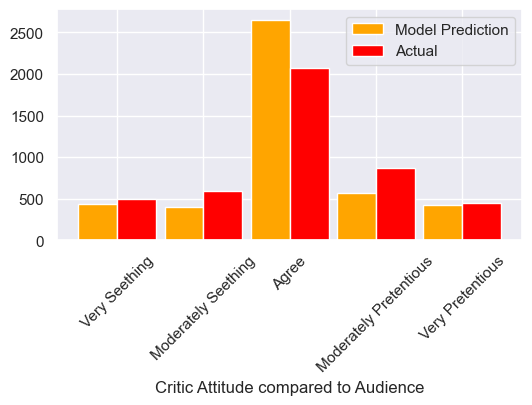

In [197]:
x = np.arange(5)

# Set the width of the bars
bar_width = 0.45

# Create bar graphs for y_pred (blue) and y_test (red)
plt.bar(x - bar_width/2, np.bincount(y_pred), bar_width, label='Model Prediction', color='orange', align='center')
plt.bar(x + bar_width/2, np.bincount(y_test), bar_width, label='Actual', color='red', align='center')

# Add labels, a legend, and a title
plt.xlabel('Critic Attitude compared to Audience')
custom_labels = ['Very Seething', 'Moderately Seething', 'Agree', 'Moderately Pretentious', 'Very Pretentious']
plt.xticks(x, custom_labels, rotation=45)
plt.legend()
plt.savefig('BERT_categorical_pred_vs_test.png')
plt.show()

In [131]:
# Saving model
with open('BERT_categorical_outliers_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Random Forest Classifier

In [231]:
%%notify
f_cores = cores-11
fmodel = RandomForestClassifier(n_estimators=500, n_jobs=f_cores, random_state=30)
fmodel.fit(X_train_p, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=9, random_state=30)

<IPython.core.display.Javascript object>

In [228]:
fmodel.score(X_train_p, y_train)

1.0

In [229]:
fmodel.score(X_test_p, y_test)

0.6832811801519892

In [ ]:
importances = fmodel.feature_importances_